# This is a Notebook to help reading and processing data.

First you need to follow the instructions in the README.md file to download the data. You have at your disposal the following datasets:
- `clipart`: A dataset of drawing images. (20 classes) [🔗](https://github.com/naoto0804/cross-domain-detection)
- `coco`: A dataset of natural (normal) images. (80 classes) [🔗](https://cocodataset.org/#home)
- `comic`: A dataset of images from comic books. (6 classes) [🔗](https://github.com/naoto0804/cross-domain-detection)
- `crowdhuman`: A dataset for detecting human in a crowd. (10 classes) [🔗](https://www.crowdhuman.org/)
- `deepfruits`: A dataset of fruits. (7 classes)
- `dior`: An aerial images dataset. (20 classes) [🔗](https://arxiv.org/pdf/1909.00133)
- `dota`: An aerial images dataset. (16 classes) [🔗](https://captain-whu.github.io/DOTA/dataset.html)
- `fashionpedia`: A dataset with everyday and celebrity event fashion images. (46 classes) [🔗](https://fashionpedia.github.io/home/Fashionpedia_download.html)
- `kitty`: A dataset for autonomous vehicle. (4 classes) [🔗](https://www.cvlibs.net/datasets/kitti/)
- `oktoberfest`: A dataset aquired during Schanzer Almfest at Ingolstadt in 2018. (15 classes) [🔗](https://github.com/a1302z/OktoberfestFoodDataset)
- `sixray`: A dataset with security inspection x-ray images. (5 classes) [🔗](https://github.com/MeioJane/SIXray)
- `visdrone`: A dataset with images taken from drones. (10 classes) [🔗](https://github.com/VisDrone/VisDrone-Dataset)
- `watercolor`: A dataset of drawing images using watercolor. (4 classes) [🔗](https://github.com/naoto0804/cross-domain-detection)

Each dataset come with different split: `train`, `validation` and/or `test`. For each dataset, you have:
- a folder containing the barycenter and the [variance/covariance matrix](https://en.wikipedia.org/wiki/Covariance_matrix) for each class (we may investigate whether this might be useful for estimating domain shift in the future).
- a folder containg the feature vectors. For now, we take only `coco` dataset as our source domain dataset, so all those features were been extracted using a pre-trained model on `coco` dataset. You have there the feature vectors for 10 objects per class, selected randomly. (because it is too heavy to stoke the whole dataset object's features).

I think this represents a good starting point, once we have the first estimations of domain shift and a working code, we may start exploring with more images.


So here are the steps we will try to follow:
- Please read this code and understand it. (you may need to read some resources about [PCA](https://en.wikipedia.org/wiki/Principal_component_analysis))
- Look for distances that can fit our problem and try to implement them. (this distances can be a starting point [Mahalanobis distance](https://en.wikipedia.org/wiki/Mahalanobis_distance), [KL Divergence](https://en.wikipedia.org/wiki/Kullback%E2%80%93Leibler_divergence), [Wasserstein distance](https://en.wikipedia.org/wiki/Wasserstein_metric))
- Compare the results with models performance that I will provide in the future.

# Reading and processing data

### Imports

In [1]:
import os
import pickle
import random
import tqdm
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn.functional as F
from sklearn.decomposition import PCA

### Reading data

In [14]:
# Just defining the colors for nice looking graphs

colors_dict = {'COCO': '#9D6FD7',
               'CrowdHuman': '#E6C8C7',
               'DIOR': '#003A37',
               'DOTA': '#8AFF66',
               'DeepFruits': '#284D26',
               'KITTI': '#F65794',
               'Oktoberfest': '#804E96',
               'SIXray': '#C05E5A',
               'VisDrone': '#458BBC',
               'clipart': '#C83F0F',
               'comic': '#3C7503',
               'fashionpedia': '#3B9F21',
               'watercolor': '#E68C70'}

In [6]:
dataset_list = sorted(os.listdir('data/class_barycenter'))
dataset_list

['COCO_train',
 'COCO_val',
 'CrowdHuman_test',
 'CrowdHuman_train',
 'CrowdHuman_val',
 'DIOR_test',
 'DIOR_train',
 'DIOR_val',
 'DOTA_test',
 'DOTA_train',
 'DOTA_val',
 'DeepFruits_test',
 'DeepFruits_train',
 'DeepFruits_val',
 'KITTI_test',
 'KITTI_train',
 'KITTI_val',
 'Oktoberfest_test',
 'Oktoberfest_train',
 'Oktoberfest_val',
 'SIXray_test',
 'SIXray_train',
 'SIXray_val',
 'VisDrone_test',
 'VisDrone_train',
 'VisDrone_val',
 'clipart_test',
 'clipart_train',
 'clipart_val',
 'comic_test',
 'comic_train',
 'comic_val',
 'fashionpedia_test',
 'fashionpedia_train',
 'fashionpedia_val',
 'watercolor_test',
 'watercolor_train',
 'watercolor_val']

In [9]:
# This is how we can read the data
features = []
names = []
for dataset in dataset_list:
    classes = [x for x in sorted(os.listdir(os.path.join('data/class_barycenter', dataset)),
                                 key=lambda item: (int(item.partition('_')[0])
                                                   if item[0].isdigit() else float('inf'), item))
               if x[-5] == 'n']
    for class_id in classes:
        with open(os.path.join('data/class_barycenter', dataset, class_id), 'rb') as f:
            mean = pickle.load(f)
        features.append(mean.cpu().numpy())
        names.append(dataset + class_id)

In [11]:
names = [name.split('_')[0] for name in names]

In [10]:
features = np.array(features)
features.shape

(625, 1024)

If at this step you get an error, either because you torch installation only supports CPU or because you get CUDA out of memory error, you can try to run the code using colab, it should run successfully.

### Processing data

In [12]:
pca = PCA(n_components=3)
pca_features = pca.fit_transform(features)
pca_features.shape

(625, 3)

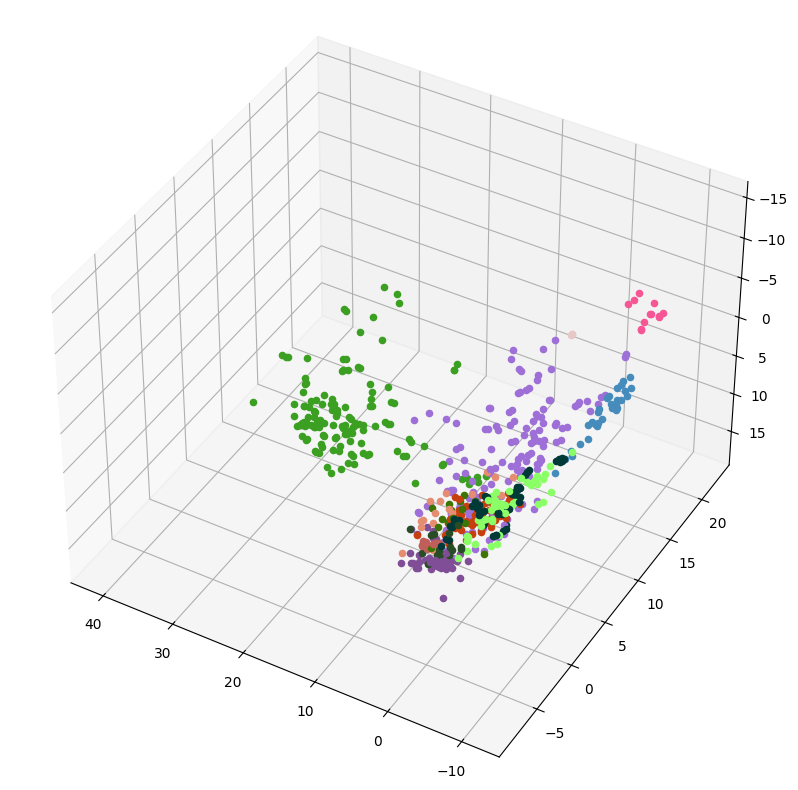

In [15]:
# % matplotlib inline

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.view_init(-140, 60)
fig.set_size_inches(10, 10)

visited = []

for i in range(pca_features.shape[0]):
    ax.scatter(pca_features[i, 0], pca_features[i, 1], pca_features[i, 2], color=colors_dict[names[i].split('_')[0]],
               label=names[i].split('_')[0])

handles, labels = ax.get_legend_handles_labels()
handle_list, label_list = [], []
for handle, label in zip(handles, labels):
    if label not in label_list:
        handle_list.append(handle)
        label_list.append(label)

# ax.legend(handle_list, label_list)
plt.show()

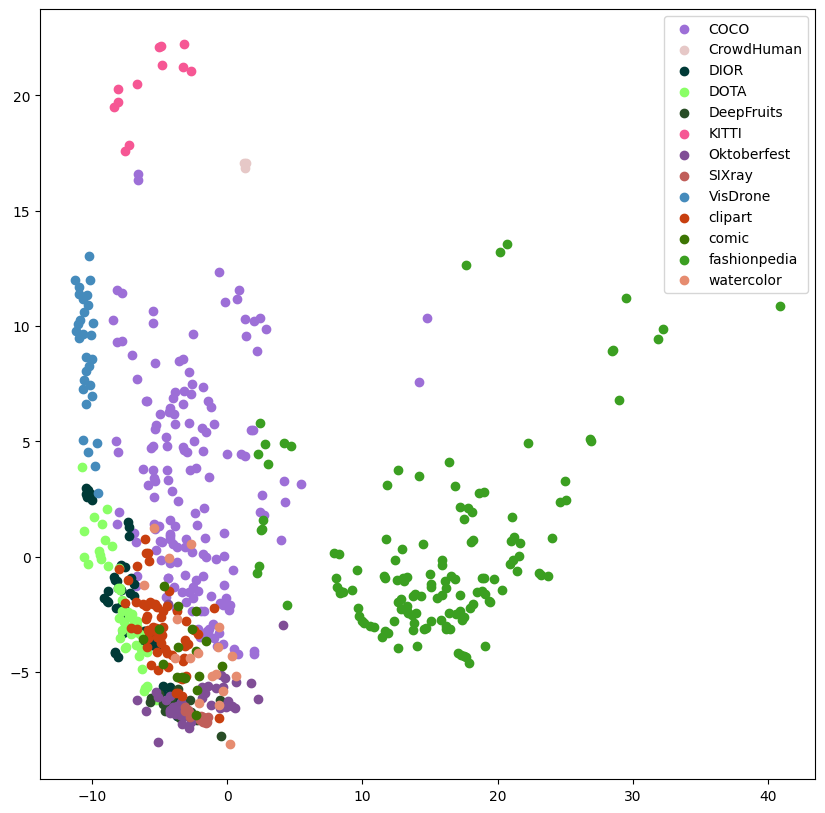

In [16]:
fig, ax = plt.subplots()
fig.set_size_inches(10, 10)

visited = []

for i in range(pca_features.shape[0]):
    ax.scatter(pca_features[i, 0], pca_features[i, 1], color=colors_dict[names[i]], label=names[i])

handles, labels = ax.get_legend_handles_labels()
handle_list, label_list = [], []
for handle, label in zip(handles, labels):
    if label not in label_list:
        handle_list.append(handle)
        label_list.append(label)

ax.legend(handle_list, label_list)
plt.show()

In [17]:
dataset = 'DOTA_train'

class_features = []
class_number = []

classes = os.listdir(os.path.join('data/class_features', dataset))
for c in classes:
    with open(os.path.join('data/class_features', dataset, c, 'mean.pkl'), 'rb') as f:
        mean = pickle.load(f)
    class_features.append(mean.cpu().numpy())
    class_number.append(-1)
    for i in range(10):
        with open(os.path.join('data/class_features', dataset, c, str(i) + '.pkl'), 'rb') as f:
            image_f = pickle.load(f)
        class_features.append(image_f.squeeze().cpu().numpy())
        class_number.append(c)

class_features = np.array(class_features)
class_features.shape

(176, 1024)

In [18]:
pca = PCA(n_components=2)
pca_features = pca.fit_transform(class_features)
pca_features.shape

(176, 2)

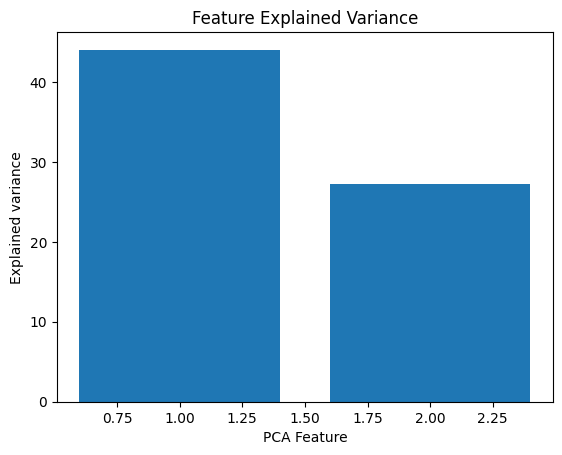

In [19]:
%matplotlib inline
plt.bar(
    range(1, len(pca.explained_variance_) + 1),
    pca.explained_variance_
)

plt.xlabel('PCA Feature')
plt.ylabel('Explained variance')
plt.title('Feature Explained Variance')
plt.show()

In [20]:
nb_classes = len(list(set(class_number))) - 1
colors_dict = {}

color = ["#" + ''.join([random.choice('0123456789ABCDEF') for j in range(6)])
         for i in range(nb_classes)]

for c in range(nb_classes):
    colors_dict[c] = color[c]

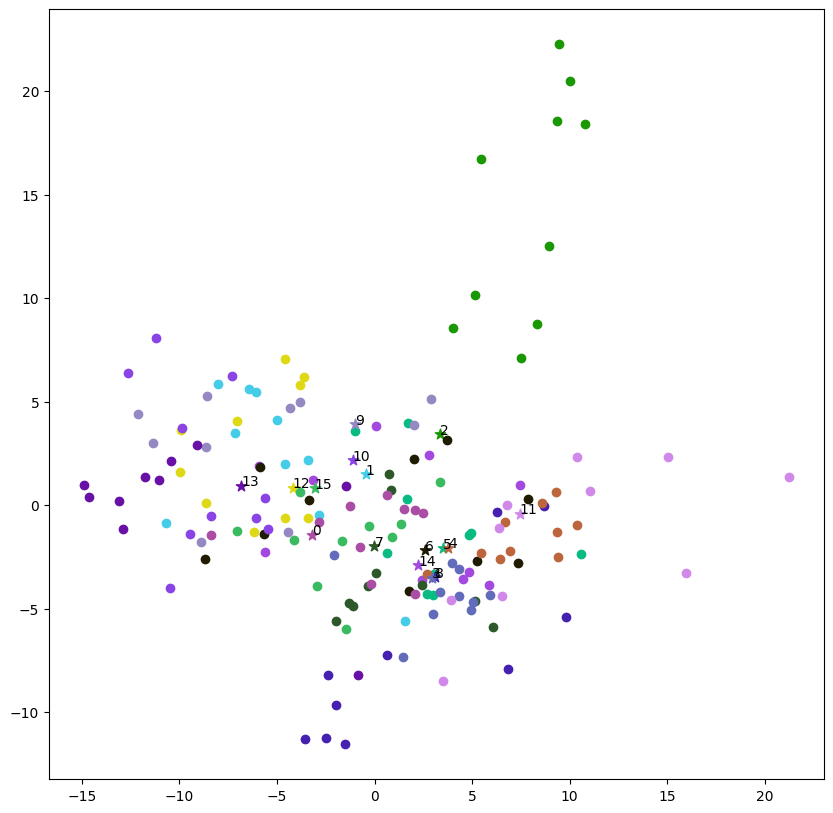

In [21]:
# %matplotlib inline

fig, ax = plt.subplots()
fig.set_size_inches(10, 10)

for i, c in enumerate(class_number):
    if c == -1:
        ax.scatter(pca_features[i, 0], pca_features[i, 1], color=colors_dict[int(class_number[i + 1])], marker='*',
                   s=60)
        ax.text(pca_features[i, 0], pca_features[i, 1], int(class_number[i + 1]))
    else:
        ax.scatter(pca_features[i, 0], pca_features[i, 1], color=colors_dict[int(c)])

plt.show()